# Fisher Information and Effective Dimension

This Jupyter notebook was created by [Umberto Borso](https://www.linkedin.com/in/umberto-borso-1990a11a1/) and is part of the Semester Project titled *"Quantum Advantage in Machine Learning: Investigating Entanglement and Quantum Feature Maps in Neural Networks"*. This nootebook contains part of the code used to analyze how the design choices of different Quantum feature maps and Variational Circuits affect the performance of a Quantum Neural Network in terms of Fisher Information and Effective Dimension. 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes, ZZFeatureMap, ExcitationPreserving, PauliFeatureMap

from qiskit.utils import algorithm_globals

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/drive/MyDrive/Colab Notebooks/libraries'
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/qiskit-machine-learning-main')

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [ ]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
blocks = 9
###################################################################################
num_qubits = 4
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 100
num_weight_samples = 100


In [ ]:
# create a feature map
feature_map = ZZFeatureMap(4, reps=1)
# create a variational circuit
ansatz = ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='sca',skip_final_rotation_layer=True)


qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))


In [ ]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
)


global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

d = qnn.num_weights
print(d)

40


In [ ]:
grads, output = global_ed.run_monte_carlo()

np.save("/content/drive/MyDrive/Colab Notebooks/ExcitPres_sca_grads.npy", grads)
np.save("/content/drive/MyDrive/Colab Notebooks/ExcitPres_sca_output.npy", output)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
grads = np.load("/content/drive/MyDrive/Colab Notebooks/Circuit_2_grads.npy")
output = np.load("/content/drive/MyDrive/Colab Notebooks/Circuit_2_output.npy")

In [ ]:
# step 2: compute as many fisher info. matrices as (input, params) sets
fisher = global_ed.get_fisher_information(gradients=grads, model_outputs=output)

# step 3: get normalized fisher info matrices
normalized_fisher, _ = global_ed.get_normalized_fisher(fisher)

# step 4: compute eff. dim
effective_dimensions = global_ed._get_effective_dimension(normalized_fisher, n)

In [ ]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(effective_dimensions) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()

NameError: ignored

In [ ]:
fne = np.array([fisher,normalized_fisher,effective_dimensions])
np.save("/content/drive/MyDrive/Colab Notebooks/Circuit_2_fne.npy", fne)

<ipython-input-15-6ce65aa844b3>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fne = np.array([fisher,normalized_fisher,effective_dimensions])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# This code generates the distribution of eigenvalues plot in the main manuscript

# colors:
rooi = np.array([255, 29, 0])/255
blou = np.array([0, 150, 236])/255
groen = np.array([0,208,0])/255

# load data
fhat_classical = normalized_fisher
fhat_easy_qnn = normalized_fisher
fhat_qnn = normalized_fisher

e1=[]
e2=[]
e3=[]

# get the eigenvalues for each sample
for i in range(100):
    e1.append(np.linalg.eigh(fhat_classical[i])[0])
    e2.append(np.linalg.eigh(fhat_easy_qnn[i])[0])
    e3.append(np.linalg.eigh(fhat_qnn[i])[0])


# take the average of the eigenvalues
e1 = np.average(e1, axis=0)
e2 = np.average(e2, axis=0)
e3 = np.average(e3, axis=0)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Classical neural network')
counts, bins = np.histogram(e1, bins=np.linspace(np.min(e1), np.max(e1), 40))
mid_points = (bins[1:] + bins[:-1])/2
x1, y1 = mid_points, counts/np.sum(counts)
plt.ylim(0)

# smooth the plot

x_new = np.linspace(np.min(x1), np.max(x1), 10)
a_BSpline = interpolate.make_interp_spline(x1, y1)
y_new = a_BSpline(x_new)
plt.plot(x_new, y_new, color=rooi)
plt.ylabel('density')

###########
counts, bins = np.histogram(e2, bins=np.linspace(np.min(e2), np.max(e2), 40))
mid_points = (bins[1:] + bins[:-1])/2
x2, y2 = mid_points, counts/np.sum(counts)

plt.subplot(1,3,2)
plt.title('Easy quantum model')
plt.ylim((0,1))
x_new = np.linspace(np.min(x2), np.max(x2), 10)
a_BSpline = interpolate.make_interp_spline(x2, y2)
y_new = a_BSpline(x_new)
plt.plot(x_new, y_new, color = blou)
plt.xlabel('value of the eigenvalues')
#########
counts, bins = np.histogram(e3, bins=np.linspace(np.min(e3), np.max(e3), 40))
mid_points = (bins[1:] + bins[:-1])/2
x3, y3 = mid_points, counts/np.sum(counts)
plt.subplot(1,3,3)
plt.title('Quantum neural network')
plt.ylim(0)
x_new = np.linspace(np.min(x3), np.max(x3), 10)
a_BSpline = interpolate.make_interp_spline(x3, y3)
y_new = a_BSpline(x_new)
plt.plot(x_new, y_new, color = groen)
plt.savefig('fisher_3comp_in4_zoomed_out_only.eps', format='eps', dpi=1000)
plt.show()

# repeat the process for just the eigenvalues < 1

###############################################################
e11 = []
for i in range(len(e1)):
    if e1[i] < 1:
        e11.append(e1[i])

e22 = []
for i in range(len(e2)):
    if e2[i] >0 and e2[i] <1:
        e22.append(e2[i])

e33 = []
for i in range(len(e3)):
    if e3[i] >0 and e3[i] <1:
        e33.append(e3[i])

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Classical neural network')
counts, bins = np.histogram(e11, bins=np.linspace(np.min(e11), np.max(e11), 40))
mid_points = (bins[1:] + bins[:-1])/2
x1, y1 = mid_points, counts/np.sum(counts)
plt.ylim((0,1))
plt.xlim((0,1))
x_new = np.linspace(np.min(x1), np.max(x1), 10)
a_BSpline = interpolate.make_interp_spline(x1, y1)
y_new = a_BSpline(x_new)
plt.ylabel('density')
plt.plot(x_new, y_new, color=rooi)

###########
counts, bins = np.histogram(e22, bins=np.linspace(np.min(e22), np.max(e22), 40))
mid_points = (bins[1:] + bins[:-1])/2
x2, y2 = mid_points, counts/np.sum(counts)

plt.subplot(1,3,2)
plt.ylim((0,1))
plt.xlim((0,1))
x_new = np.linspace(np.min(x2), np.max(x2), 10)
a_BSpline = interpolate.make_interp_spline(x2, y2)
y_new = a_BSpline(x_new)
plt.title('Easy quantum model')
plt.xlabel('value of the eigenvalues')
plt.plot(x_new, y_new, color=blou)

#########
counts, bins = np.histogram(e33, bins=np.linspace(np.min(e33), np.max(e33), 40))
mid_points = (bins[1:] + bins[:-1])/2
x, y = mid_points, counts/np.sum(counts)

plt.subplot(1,3,3)
x_new = np.linspace(np.min(x), np.max(x), 10)
a_BSpline = interpolate.make_interp_spline(x, y)
y_new = a_BSpline(x_new)
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot(x_new, y_new, color=groen)
plt.title('Quantum neural network')
plt.savefig('fisher_3comp_in4_zoomed_in_only.eps', format='eps', dpi=1000)
plt.show()

NameError: ignored

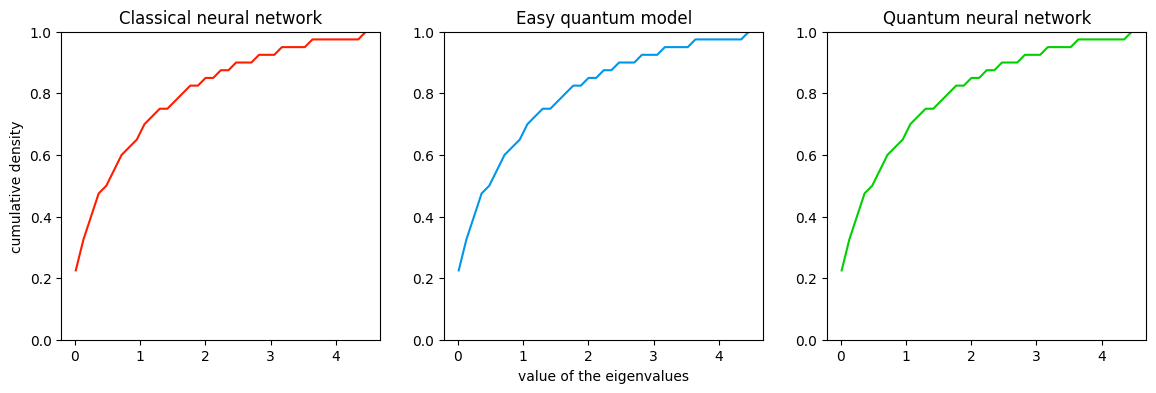

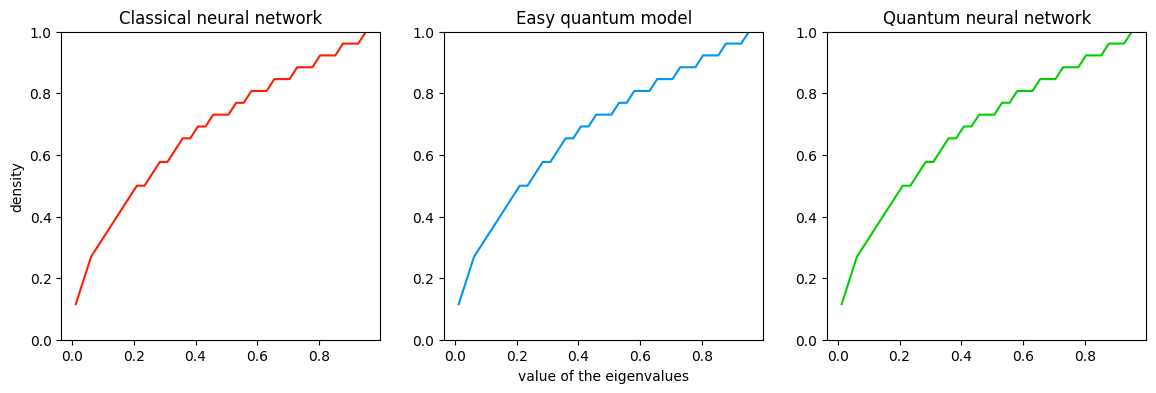

In [ ]:


plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Classical neural network')
counts, bins = np.histogram(e1, bins=np.linspace(np.min(e1), np.max(e1), 40))
cumulative = np.cumsum(counts)/np.sum(counts)
# plot the cumulative function
plt.plot(bins[:-1], cumulative, c=rooi)
plt.ylim((0,1))
plt.ylabel('cumulative density')

###########
counts, bins = np.histogram(e2, bins=np.linspace(np.min(e2), np.max(e2), 40))
plt.subplot(1,3,2)
plt.title('Easy quantum model')
plt.ylim((0,1))
cumulative = np.cumsum(counts)/np.sum(counts)
# plot the cumulative function
plt.plot(bins[:-1], cumulative, c=blou)
plt.xlabel('value of the eigenvalues')
#########
counts, bins = np.histogram(e3, bins=np.linspace(np.min(e3), np.max(e3), 40))
plt.subplot(1,3,3)
plt.title('Quantum neural network')
plt.ylim((0,1))
cumulative = np.cumsum(counts)/np.sum(counts)
# plot the cumulative function
plt.plot(bins[:-1], cumulative, c=groen)
#plt.savefig('fisher_3comp_in4_zoomed_out_only.eps', format='eps', dpi=1000)
plt.show()

# repeat the process for just the eigenvalues < 1

###############################################################
e11 = []
for i in range(len(e1)):
    if e1[i] < 1:
        e11.append(e1[i])

e22 = []
for i in range(len(e2)):
    if e2[i] >0 and e2[i] <1:
        e22.append(e2[i])

e33 = []
for i in range(len(e3)):
    if e3[i] >0 and e3[i] <1:
        e33.append(e3[i])

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Classical neural network')
counts, bins = np.histogram(e11, bins=np.linspace(np.min(e11), np.max(e11), 40))
cumulative = np.cumsum(counts)/np.sum(counts)
# plot the cumulative function
plt.plot(bins[:-1], cumulative, c=rooi)
plt.ylim((0,1))
plt.ylabel('density')

###########
counts, bins = np.histogram(e22, bins=np.linspace(np.min(e22), np.max(e22), 40))
plt.subplot(1,3,2)
plt.ylim((0,1))
cumulative = np.cumsum(counts)/np.sum(counts)
# plot the cumulative function
plt.plot(bins[:-1], cumulative, c=blou)
plt.title('Easy quantum model')
plt.xlabel('value of the eigenvalues')


#########
counts, bins = np.histogram(e33, bins=np.linspace(np.min(e33), np.max(e33), 40))
plt.subplot(1,3,3)
cumulative = np.cumsum(counts)/np.sum(counts)
# plot the cumulative function
plt.plot(bins[:-1], cumulative, c=groen)
plt.ylim((0,1))

plt.title('Quantum neural network')
plt.savefig('cum_plot.eps', format='eps', dpi=1000)
plt.show()